In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import copy
import scipy.ndimage as ndimage
from PIL import Image, ImageOps


def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

data = []
label = []
labels = []
images = []


# load image and change the dtype into array
for i in range(10):
    for j in range(10):
        image = tf.keras.preprocessing.image.load_img('./image/0'+str(i)+str(j)+'.png')
        images.append(image)
        input_arr = keras.preprocessing.image.img_to_array(image)
        data.append(input_arr)
        
for i in range(10):
    for j in range(10):
        image = tf.keras.preprocessing.image.load_img('./image/better_0'+str(i)+str(j)+'.png')
        images.append(image)
        input_arr = keras.preprocessing.image.img_to_array(image)
        data.append(input_arr)
    
for i in range(10):
    for j in range(10):
        image = tf.keras.preprocessing.image.load_img('./image/doodle_0'+str(i)+str(j)+'.png')
        images.append(image)
        input_arr = keras.preprocessing.image.img_to_array(image)
        data.append(input_arr)

# create one-hot label
for k in range(100):
    label.append(0)
for m in range(100):
    label[m] = 1
    temp = copy.deepcopy(label)
    labels.append(temp)
    label[m] = 0 
    
datas = np.array(data)
datas = datas / 255.0
labels = np.array(labels)
labels = labels / 1.0  

temp = tf.concat([labels, labels], axis=0)
labels = tf.concat([temp,labels], axis=0)

test_labels = copy.deepcopy(labels)

print(datas.shape)
print(labels.shape)

(300, 512, 512, 3)
(300, 100)


In [2]:
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='logs', update_freq='epoch', write_graph=True, profile_batch=0)

In [3]:
# data augmentation function
def data_aug(datas):
    
    resized_datas = copy.deepcopy(datas)
    
    # 1) resize the image
    for i in range(len(resized_datas)):
        resize = int(np.round(512*np.random.uniform(0.8,1,1)))
        temp = tf.image.resize(datas[i], [resize, resize])
        if resize >= 512:
            temp2 = tf.image.resize_with_crop_or_pad(temp, 512, 512)
            resized_datas[i] = temp2
        elif resize < 512:
            imgtemp = keras.preprocessing.image.array_to_img(temp)
            delta_w = 512 - resize
            delta_h = 512 - resize
            padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
            imgtemp2 = ImageOps.expand(imgtemp, padding, fill=(255,255,255))
            temp2 = keras.preprocessing.image.img_to_array(imgtemp2)
            resized_datas[i] = temp2

    def random_rotate_image(image):
        image = ndimage.rotate(image, np.random.uniform(-45, 45), reshape=False, mode='constant', cval=255.0)
        return image

    rot_res_datas = copy.deepcopy(datas)

    # 2) rotate the resized image
    for i in range(len(rot_res_datas)):
        rot_res_datas[i] = random_rotate_image(resized_datas[i])
        
    train_datas = copy.deepcopy(datas)     
    
    # 3) shift the rotated and resized image
    for i in range(len(train_datas)):
        train_datas[i] = tf.keras.preprocessing.image.random_shift(rot_res_datas[i], 0.1, 0.1, 
                                                                   row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant',
                                                                   cval=255.0)

    result = tf.image.resize(train_datas, [220,220])
    result = result / 255.0
    
    return result

In [27]:
# create CNN model (using built-in 'Sequntial' methods)
model = tf.keras.Sequential([ tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2', input_shape=(220, 220, 3)),
                              tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(0.01),
                              tf.keras.layers.MaxPooling2D((2, 2)),
                              tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(0.01),
                              tf.keras.layers.MaxPooling2D((2,2)),
                              tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(0.01),
                              tf.keras.layers.MaxPooling2D((2,2)),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(0.01),
                              tf.keras.layers.MaxPooling2D((2,2)),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',kernel_regularizer='l2'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.LeakyReLU(0.01),
                              tf.keras.layers.MaxPooling2D((2,2)),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(100, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 220, 220, 64)      1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 220, 220, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 110, 110, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 110, 110, 128)     1

In [4]:
# create CNN model (user defined version)
class MyVGG19(tf.keras.Model):
    
    def __init__(self):
        super(MyVGG19, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv2 = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.LeakyReLU(0.01)
        self.mxp1 = tf.keras.layers.MaxPooling2D((2,2))
        
        self.conv3 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv4 = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.LeakyReLU(0.01)
        self.mxp2 = tf.keras.layers.MaxPooling2D((2,2))        
        
        self.conv5 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv6 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv7 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')        
        self.conv8 = tf.keras.layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer='l2')     
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.LeakyReLU(0.01)
        self.mxp3 = tf.keras.layers.MaxPooling2D((2,2)) 
        
        self.conv9 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv10 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv11 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')        
        self.conv12 = tf.keras.layers.Conv2D(512, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer='l2')     
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.relu4 = tf.keras.layers.LeakyReLU(0.01)
        self.mxp4 = tf.keras.layers.MaxPooling2D((2,2)) 
        
        self.conv13 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv14 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')
        self.conv15 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer='l2')        
        self.conv16 = tf.keras.layers.Conv2D(512, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer='l2')     
        self.bn5 = tf.keras.layers.BatchNormalization()
        self.relu5 = tf.keras.layers.LeakyReLU(0.01)
        self.mxp5 = tf.keras.layers.MaxPooling2D((2,2)) 
        
        self.flt = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal')
        self.drp1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')
        self.drp2 = tf.keras.layers.Dropout(0.5)
        self.dense3 = tf.keras.layers.Dense(100, activation='softmax')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.mxp1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.mxp2(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.mxp3(x)        
        
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.mxp4(x)          

        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.conv16(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.mxp5(x)
        
        x = self.flt(x)
        x = self.dense1(x)
        x = self.drp1(x)
        x = self.dense2(x)
        x = self.drp2(x)
        outputs = self.dense3(x)
        return outputs
    
myvgg = MyVGG19()
input_shape = (None, 220, 220, 3)
myvgg.build(input_shape)
myvgg.summary()

Model: "my_vg_g19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  14

In [23]:
# train model with augmented datas
# need to change the learning rate 
# 0.001 -> 0.0005 -> 0.0001 -> 0.00005 -> 0.00001, for each learning rate, tried about 20x10 epochs
myvgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

for i in range(10):
    auged_datas = data_aug(datas)
    myvgg.fit(auged_datas, labels, batch_size=10, epochs=10)

Epoch 1/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5949 - accuracy: 0.8533
Epoch 2/10
30/30 [==============================] - 2s 54ms/step - loss: 0.6654 - accuracy: 0.8400
Epoch 3/10
30/30 [==============================] - 2s 54ms/step - loss: 0.6227 - accuracy: 0.8400
Epoch 4/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5746 - accuracy: 0.8500
Epoch 5/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5754 - accuracy: 0.8500
Epoch 6/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5006 - accuracy: 0.8833
Epoch 7/10
30/30 [==============================] - 2s 54ms/step - loss: 0.6875 - accuracy: 0.8133
Epoch 8/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5567 - accuracy: 0.8700
Epoch 9/10
30/30 [==============================] - 2s 54ms/step - loss: 0.4717 - accuracy: 0.8800
Epoch 10/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5393 - accuracy: 0.8533
Epoch 1/1

In [26]:
# save trained model
!mkdir -p myvgg_saved_model
myvgg.save('myvgg_saved_model/my_model') 

INFO:tensorflow:Assets written to: myvgg_saved_model/my_model/assets


In [61]:
test_datas = tf.image.resize(datas, [220,220])
    
test_loss, test_acc = myvgg.evaluate(test_datas, labels, verbose=2)
print(test_acc)

pred = myvgg.predict(test_datas)

for i in range(10):
    print(np.argmax(pred[i]))

10/10 - 0s - loss: 0.1151 - accuracy: 0.9967
0.996666669845581
0
1
2
3
4
5
6
7
8
9


43
23
59
66
81
None
None
None
None
None


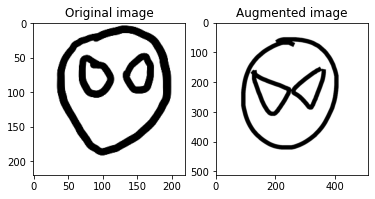

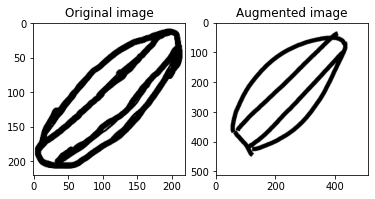

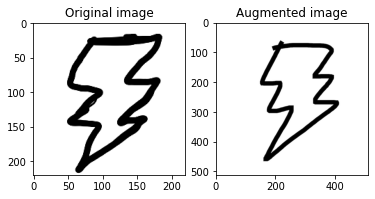

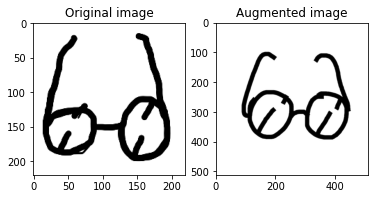

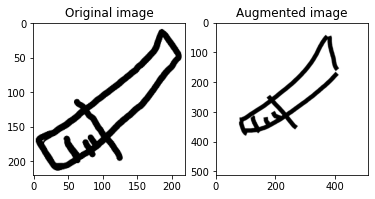

In [62]:
# load test image and change the dtype into array
tdata = []

for i in range(1, 6):
    image = tf.keras.preprocessing.image.load_img('./test_image/10'+str(i)+'.png')
    images.append(image)
    input_arr = keras.preprocessing.image.img_to_array(image)
    tdata.append(input_arr)
    
tdatas = np.array(tdata)
tdatas = tdatas / 255.0

t_datas = tf.image.resize(tdatas, [220,220])

predicts = myvgg.predict(t_datas)

for i in range(5):
    print(np.argmax(predicts[i]))

print(visualize(t_datas[0], datas[202]))
print(visualize(t_datas[1], datas[223]))
print(visualize(t_datas[2], datas[259]))
print(visualize(t_datas[3], datas[266]))
print(visualize(t_datas[4], datas[281]))

In [55]:
# train model with augmented datas
# need to change the learning rate 
# 0.001 -> 0.0005 -> 0.0001 -> 0.00005 -> 0.00001, for each learning rate, tried about 20x10 epochs
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

for i in range(10):
    auged_datas = data_aug(datas)
    model.fit(auged_datas, labels, batch_size=10, epochs=10)

Epoch 1/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5374 - accuracy: 0.8800
Epoch 2/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5085 - accuracy: 0.8867
Epoch 3/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5489 - accuracy: 0.8433
Epoch 4/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5954 - accuracy: 0.8500
Epoch 5/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5428 - accuracy: 0.8667
Epoch 6/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5573 - accuracy: 0.8867
Epoch 7/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5654 - accuracy: 0.8467
Epoch 8/10
30/30 [==============================] - 2s 54ms/step - loss: 0.4810 - accuracy: 0.8800
Epoch 9/10
30/30 [==============================] - 2s 54ms/step - loss: 0.4397 - accuracy: 0.8733
Epoch 10/10
30/30 [==============================] - 2s 54ms/step - loss: 0.5005 - accuracy: 0.8833
Epoch 1/1

In [63]:
# save trained model
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [64]:
# load saved model
new_model = tf.keras.models.load_model('saved_model/my_model')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 220, 220, 64)      1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 220, 220, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 110, 110, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 110, 110, 128)     1

In [53]:
test_datas = tf.image.resize(datas, [220,220])
    
test_loss, test_acc = new_model.evaluate(test_datas, labels, verbose=2)
print(test_acc)

10/10 - 0s - loss: 0.1604 - accuracy: 0.9967
0.996666669845581


In [48]:
# test model and check the accuracy (with label data)
test_datas = tf.image.resize(datas, [220,220])
    
test_loss, test_acc = model.evaluate(test_datas, labels, verbose=2)
print(test_acc)

10/10 - 0s - loss: 0.1604 - accuracy: 0.9967
0.996666669845581


In [49]:
predictions = model.predict(test_datas)

for i in range(10):
    print(np.argmax(predictions[i]))

0
1
2
3
4
5
6
7
8
9


43
23
59
66
81
None
None
None
None
None


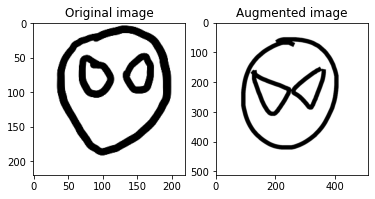

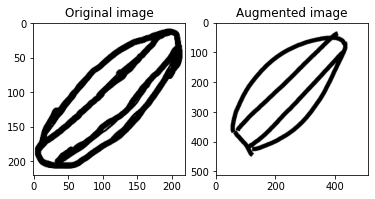

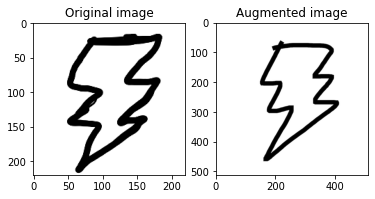

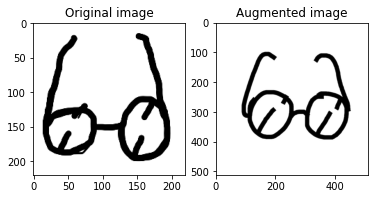

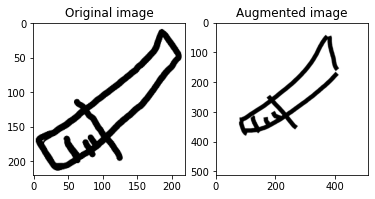

In [56]:
# load test image and change the dtype into array
tdata = []

for i in range(1, 6):
    image = tf.keras.preprocessing.image.load_img('./test_image/10'+str(i)+'.png')
    images.append(image)
    input_arr = keras.preprocessing.image.img_to_array(image)
    tdata.append(input_arr)
    
tdatas = np.array(tdata)
tdatas = tdatas / 255.0

t_datas = tf.image.resize(tdatas, [220,220])

predicts = new_model.predict(t_datas)

for i in range(5):
    print(np.argmax(predicts[i]))

print(visualize(t_datas[0], datas[202]))
print(visualize(t_datas[1], datas[223]))
print(visualize(t_datas[2], datas[259]))
print(visualize(t_datas[3], datas[266]))
print(visualize(t_datas[4], datas[281]))